<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split


%matplotlib inline

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

all_photos, all_attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(all_photos.transpose(0, 3, 1, 2),
                                                                    all_attrs, test_size=0.2, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

val_photos.shape

(2629, 3, 64, 64)

In [ ]:
def show_samples(row_one, row_two, n=5):
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display the first row
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(row_one[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the second row
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(row_two[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

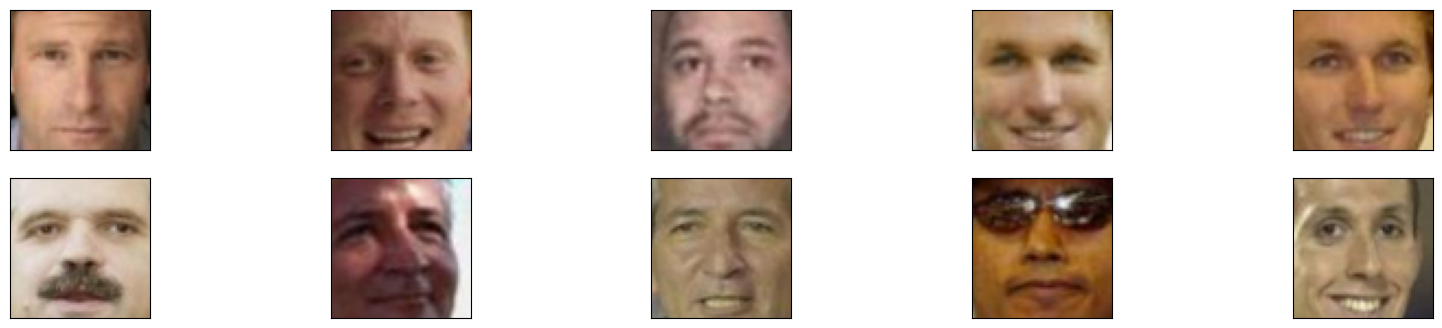

In [ ]:
show_samples(train_photos, val_photos)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 96 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, z_size):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3*64*64, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=z_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=z_size, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=3*64*64),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        # возвращаемыe переменныe - реконструкция изображения (x) и латентное представление картинки (z)
        return x, z

In [ ]:
from torchsummary import summary

autoencoder = Autoencoder(dim_code)
summary(autoencoder, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                  [-1, 256]       3,145,984
         LeakyReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
         LeakyReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 96]          12,384
            Linear-7                  [-1, 128]          12,416
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
        LeakyReLU-10                  [-1, 256]               0
           Linear-11                [-1, 12288]       3,158,016
          Sigmoid-12                [-1, 12288]               0
Total params: 6,394,720
Trainable params: 6,394,720
Non-trainable params: 0
---------------------------

In [ ]:
autoencoder.to(DEVICE)

criterion = F.mse_loss
optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs=20):
    train_loss = []
    val_loss = []

    for epoch in trange(n_epochs):
        model.train()
        train_loss_per_epoch = []
        for X_batch in train_loader:
            optimizer.zero_grad()

            X_batch = X_batch.to(DEVICE)
            reconstructed, _ = model(X_batch)

            loss = loss_fn(reconstructed, X_batch.view(X_batch.size(0), -1))

            loss.backward()
            optimizer.step()
            train_loss_per_epoch.append(loss.item())
        train_loss.append(np.mean(train_loss_per_epoch))

        model.eval()
        val_loss_per_epoch = []
        with torch.no_grad():
            for y_batch in val_loader:
                y_batch = y_batch.to(DEVICE)

                reconstructed, _ = model(y_batch)
                loss = loss_fn(reconstructed, y_batch.view(y_batch.size(0), -1))

                val_loss_per_epoch.append(loss.item())
        val_loss.append(np.mean(val_loss_per_epoch))

        # Посмотрим реконструкцию изображения на данном этапе обучения
        clear_output(wait=True)
        show_samples(y_batch.cpu().numpy(), reconstructed.view(-1, 3, 64, 64).cpu().numpy())

    return train_loss, val_loss

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

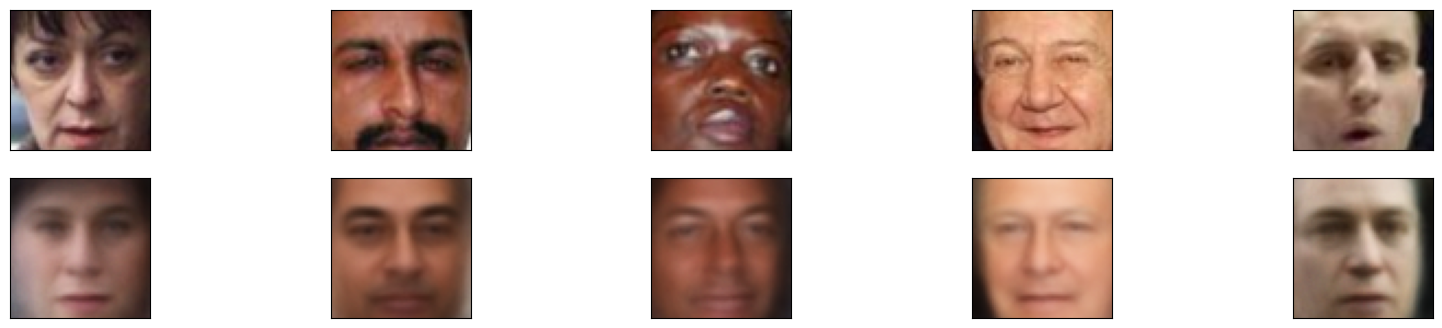

In [ ]:
tl, vl = train(autoencoder, train_loader, val_loader, optimizer, criterion)

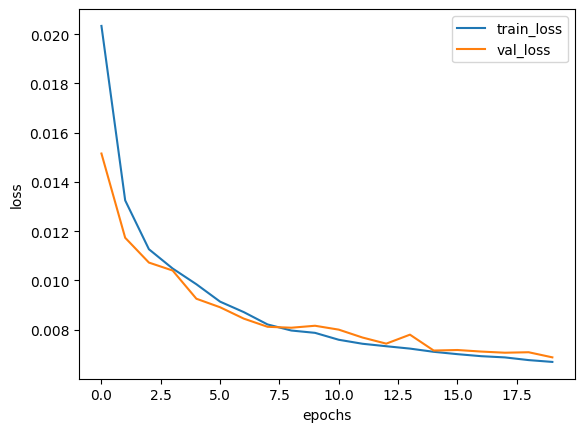

In [ ]:
# Построим кривые обучения
#plt.figure(figsize=(15, 9))
plt.plot(tl, label="train_loss")
plt.plot(vl, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

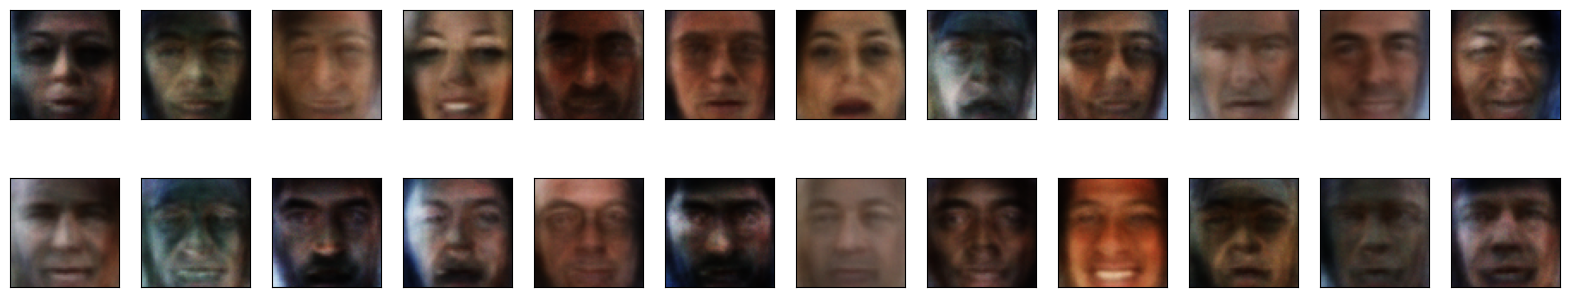

In [ ]:
# Cгенерируем 25 рандомных векторов размера latent_space
z = torch.randn(25, dim_code)
output = autoencoder.decoder(z.to(DEVICE)).view(-1, 3, 64, 64).cpu().detach().numpy()
show_samples(output[:12], output[12:], 12)

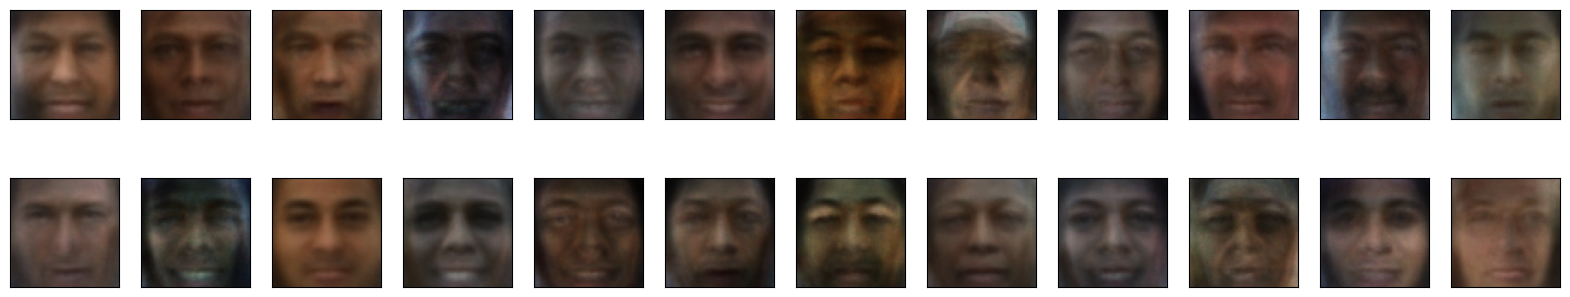

In [ ]:
# Попробуем сделать изображения более реалистичными, скорректировав распределение латентных векторов
batch = next(iter(val_loader))
lat = autoencoder.encoder(batch.to(DEVICE)).cpu().detach()

mu, sigma = lat.mean(), lat.std()
z = sigma * torch.randn(25, dim_code) + mu

output = autoencoder.decoder(z.to(DEVICE)).view(-1, 3, 64, 64).cpu().detach().numpy()
show_samples(output[:12], output[12:], 12)

В целом получилось примерно то же самое, что означает распределение латентных векторов было изначально близко к нормальному.

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

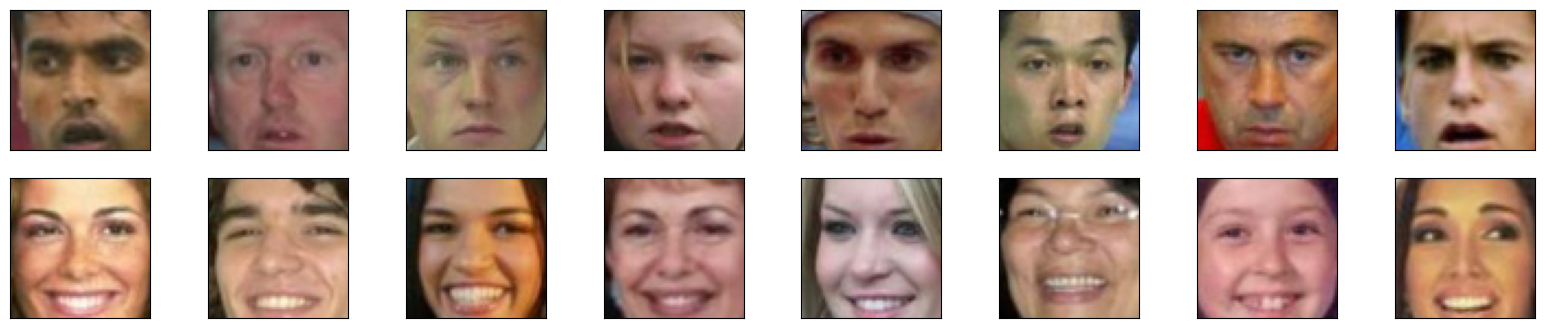

In [ ]:
# Отсортируем по возрастанию атрибута Smiling
sorted = all_attrs.sort_values('Smiling')

# Первые двадцать не улыбаюся, последние двадцать - улыбаюся
no_smile = sorted[:20].index
smile = sorted[-20:].index

# Вот они :)
show_samples(all_photos[no_smile].transpose(0, 3, 1, 2), all_photos[smile].transpose(0, 3, 1, 2), 8)

In [ ]:
# Получим латентные векторы для изображений с улыбками и без
smile_vec = autoencoder.encoder(torch.Tensor(all_photos[smile].transpose(0, 3, 1, 2)).to(DEVICE))
no_smile_vec = autoencoder.encoder(torch.Tensor(all_photos[no_smile].transpose(0, 3, 1, 2)).to(DEVICE))

# "Золотой ключик" - вектор разницы средних значений
key = smile_vec.mean(dim=0) - no_smile_vec.mean(dim=0)
key

tensor([-0.1218,  0.0676,  0.3468,  0.2360, -0.1317, -0.7581,  0.2058,  0.5229,
         0.4897, -0.3456,  0.7866,  0.1030,  0.3250,  0.0271, -0.5339, -0.0535,
         0.6417, -0.0909,  0.5702,  0.0886, -0.5486, -0.1487,  0.1315, -0.3536,
        -0.2389, -0.3655, -0.1912,  0.7528, -0.0937,  0.0613,  0.2200, -0.1130,
        -0.0828, -0.9194,  0.5081, -0.3793,  0.3021, -0.1235, -0.4364, -0.2862,
         0.5900, -0.2620,  0.6216, -0.5585,  0.6726, -0.1856, -0.4635,  0.4916,
        -0.3073, -0.1428,  0.3248,  0.1987, -0.2557,  0.0114,  0.1514,  0.0522,
        -0.0830,  0.2056, -0.5287, -0.5281, -0.0550,  0.0829, -0.2234, -0.4873,
         0.1431, -0.2391,  0.1315,  0.2112, -0.1600, -0.3789,  0.6925,  0.2098,
         0.4310,  0.1654,  0.9478, -0.6909, -0.6322, -0.0999, -0.4840, -0.6081,
         0.0507, -0.4389, -0.4646, -0.2211,  0.5685,  0.0960,  0.0449,  0.5468,
         0.0641, -0.1390,  0.2780, -0.2812,  0.7707, -0.5006, -0.3437,  0.4125],
       device='mps:0', grad_fn=<SubBack

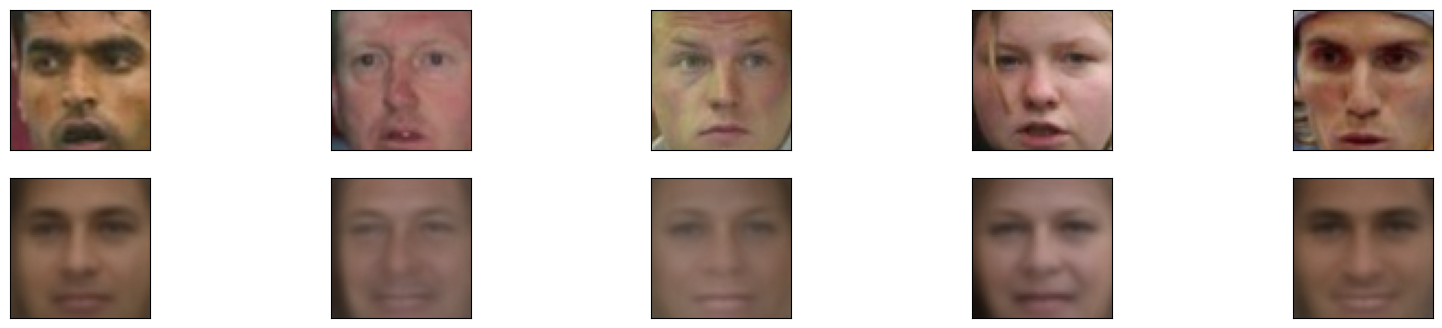

In [ ]:
# Попробуем взвешенную сумму ключа и латентного векторa изображений без улыбки
alpha = 0.3
new_vec = (1-alpha)*no_smile_vec + alpha*key

output = autoencoder.decoder(new_vec).view(-1, 3, 64, 64).cpu().detach().numpy()

show_samples(all_photos[no_smile].transpose(0, 3, 1, 2), output)

Вуаля! Вы восхитительны (больше похоже на улыбку Джоконды, чем на полноценную улыбку во весь рот, но я объясняю это тeм, что моделью служил простенький MLP :))

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class VAE(nn.Module):
    def __init__(self, z_size):
        super().__init__()

        self.z_size = z_size

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=1, kernel_size=3, padding=1),
            nn.Flatten(),
            nn.Linear(3136, 2*z_size)
        )

        self.decoder = nn.Sequential(
            torch.nn.Linear(z_size, 3136),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 64, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=0),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 1, stride=1, kernel_size=3, padding=0),
            Trim(),
            nn.Sigmoid()
        )

    def encode(self, x):
        mu, logsigma = self.encoder(x).split(self.z_size, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # латентный вектор из нормального распределения с параметрами mu и sigma
            sigma = logsigma.exp()
            sample = torch.randn_like(sigma)*sigma + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction


In [ ]:
from torchsummary import summary

dim_code = 8 # выберите размер латентного вектора

autoencoder = VAE(dim_code)
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
           Flatten-8                 [-1, 3136]               0
            Linear-9                   [-1, 16]          50,192
           Linear-10                 [-1, 3136]          28,224
        Unflatten-11             [-1, 64, 7, 7]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          36,928
        LeakyReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    Часть функции потерь, которая отвечает за "близость" латентных представлений
    """
    s = (mu*mu + logsigma.exp() - logsigma - 1).sum(dim=1)
    return s/2.

def log_likelihood1(x, reconstruction):
    """
    Часть функции потерь, которая отвечает за качество реконструкции, попробуем MSE
    """
    loss = nn.MSELoss(reduction='sum')
    return loss(reconstruction, x)/x.size(0)

def log_likelihood2(x, reconstruction):
    """
    Часть функции потерь, которая отвечает за качество реконструкции, попробуем BCE
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)/x.size(0)

def log_likelihood(x, reconstruction, alpha=50):
    """
    Часть функции потерь, которая отвечает за качество реконструкции, попробуем log hyperbolic cosine loss,
    по материалам https://openreview.net/pdf?id=rkglvsC9Ym
    """
    t = reconstruction.flatten(1) - x.flatten(1)
    lc_loss = (((alpha*t).exp() + (-alpha*t).exp())/2.).log() / alpha
    return lc_loss.sum(dim=1)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma).mean() + log_likelihood(x, reconstruction).mean()

И обучим модель:

In [ ]:
autoencoder.to(DEVICE)

criterion = loss_vae
optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
def train_vae(model, train_loader, val_loader, optimizer, loss_fn, n_epochs=20):
    train_loss = []
    val_loss = []

    for epoch in trange(n_epochs):
        model.train()
        train_loss_per_epoch = []
        for X_batch, _ in train_loader:
            optimizer.zero_grad()

            X_batch = X_batch.to(DEVICE)
            mu, logsigma, reconstructed = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma, reconstructed)

            loss.backward()
            optimizer.step()
            train_loss_per_epoch.append(loss.item())
        train_loss.append(np.mean(train_loss_per_epoch))

        model.eval()
        val_loss_per_epoch = []
        with torch.no_grad():
            for y_batch, _ in val_loader:
                y_batch = y_batch.to(DEVICE)

                mu, logsigma, reconstructed = model(y_batch)
                loss = loss_fn(y_batch, mu, logsigma, reconstructed)

                val_loss_per_epoch.append(loss.item())
        val_loss.append(np.mean(val_loss_per_epoch))

        # Посмотрим реконструкцию изображения на данном этапе обучения
        clear_output(wait=True)
        show_samples(y_batch.cpu().numpy(), reconstructed.view(-1, 1, 28, 28).cpu().numpy())

    return train_loss, val_loss

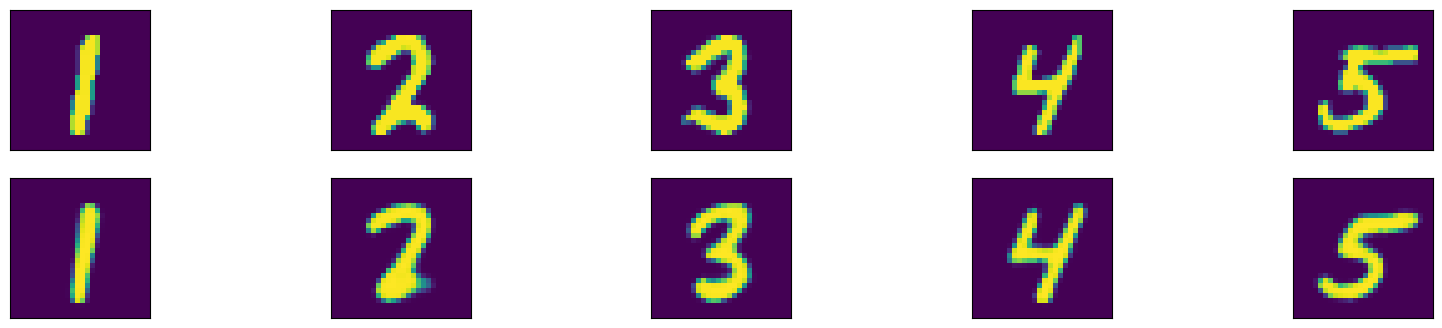

In [ ]:
tl, vl = train_vae(autoencoder, train_loader, test_loader, optimizer, criterion)

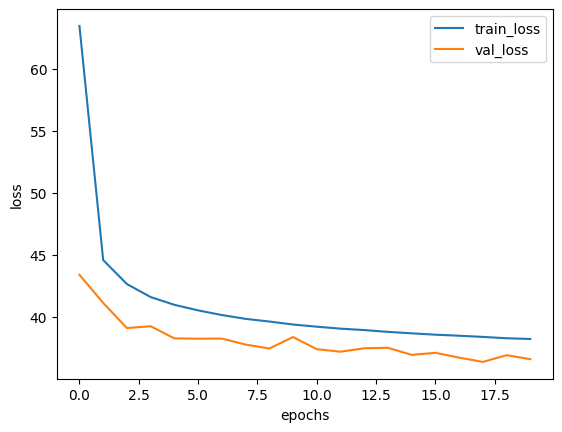

In [ ]:
# Построим кривые обучения
#plt.figure(figsize=(15, 9))
plt.plot(tl, label="train_loss")
plt.plot(vl, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

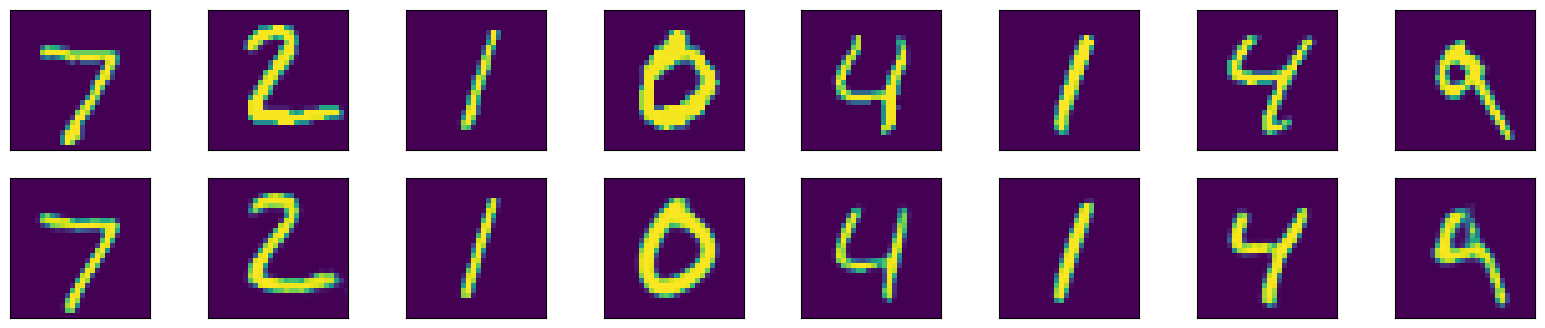

In [ ]:
autoencoder.eval()
with torch.no_grad():
    batch = next(iter(test_loader))[0]
    _, _, reconstructed = autoencoder(batch.to(DEVICE))
    output = reconstructed.cpu().numpy()

show_samples(batch.numpy(), output, 8)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

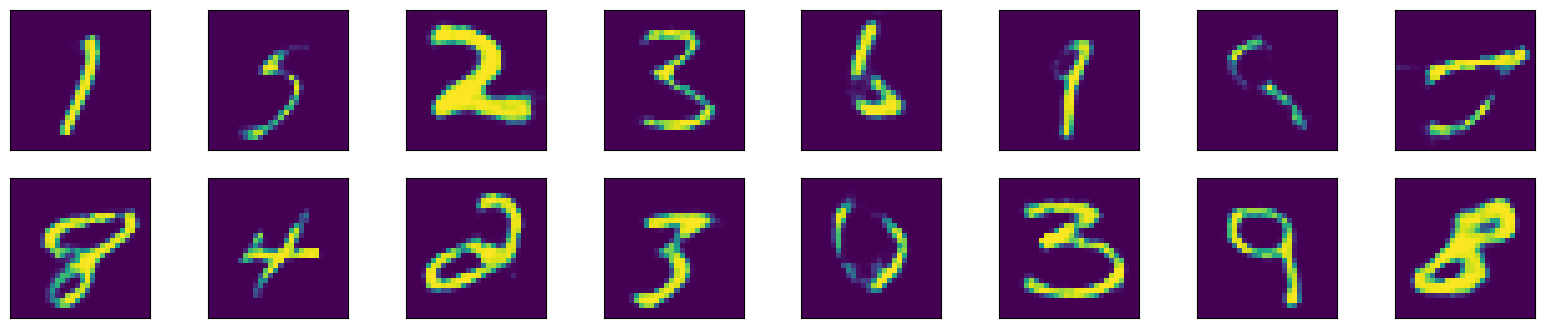

In [ ]:
# Cгенерируем 16 рандомных векторов размера latent_space
z = torch.randn(16, dim_code)
output = autoencoder.decoder(z.to(DEVICE)).cpu().detach().numpy()
show_samples(output[:8], output[8:], 8)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
NUM_SAMPLES = 7000
labels, z = [], []

autoencoder.eval()
with torch.no_grad():
    for j in range(NUM_SAMPLES):
        pic = test_loader.dataset[j][0]
        labels.append(test_loader.dataset[j][1])
        mu, _ = autoencoder.encode(pic[None, :, :, :].to(DEVICE))
        z.append(mu.detach().cpu().numpy())

In [ ]:
from sklearn.manifold import TSNE

X = torch.Tensor(z).squeeze(1)
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(X)
X_embedded.shape

(7000, 2)

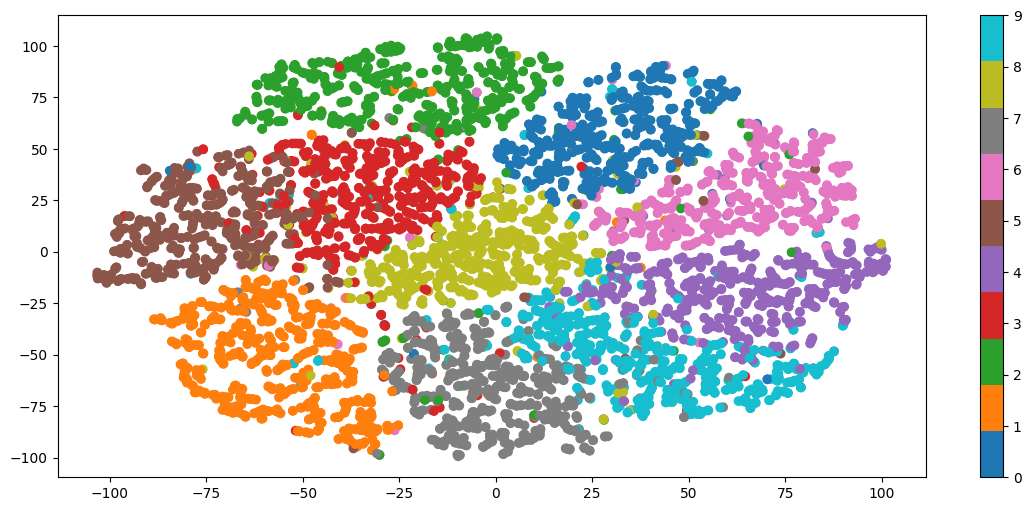

In [ ]:
plt.figure(figsize=(14, 6))
s = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(s)
plt.show()

**Что вы думаете о виде латентного представления?**

Латентные векторы сгруппированы четко, кластеры практически не пересекаются. Отдельные вкрапления соответствуют цифрам, часто трудноразличимым при написании от руки: 0 и 6, 4 и 9, и т.д.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, z_size):
        super().__init__()

        self.z_size = z_size

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28+10, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=self.z_size*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.z_size+10, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=28*28),
            nn.Sigmoid()
        )

    def encode(self, x, digit):
        onehot_encoded = F.one_hot(digit, num_classes=10)
        adjusted = torch.hstack((x.view(-1, 28*28), onehot_encoded))

        mu, logsigma = self.encoder(adjusted).split(self.z_size, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # латентный вектор из нормального распределения с параметрами mu и sigma
            sigma = logsigma.exp()
            sample = torch.randn_like(sigma)*sigma + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, digit):
        onehot_encoded = F.one_hot(digit, num_classes=10)
        adjusted = torch.hstack((z, onehot_encoded))
        return self.decoder(adjusted)

    def forward(self, x, digit=torch.zeros(2, dtype=int)):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x, digit)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, digit)
        return mu, logsigma, reconstruction

In [ ]:
from torchsummary import summary

dim_code = 8 # выберите размер латентного вектора

autoencoder = CVAE(dim_code)
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         203,520
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
         LeakyReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 16]           2,064
            Linear-6                  [-1, 128]           2,432
         LeakyReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 256]          33,024
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 784]         201,488
          Sigmoid-11                  [-1, 784]               0
Total params: 475,424
Trainable params: 475,424
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
autoencoder.to(DEVICE)

criterion = loss_vae
optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
def train_cvae(model, train_loader, val_loader, optimizer, loss_fn, n_epochs=20):
    train_loss = []
    val_loss = []

    for epoch in trange(n_epochs):
        model.train()
        train_loss_per_epoch = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            mu, logsigma, reconstructed = model(X_batch, y_batch)
            loss = loss_fn(X_batch, mu, logsigma, reconstructed)

            loss.backward()
            optimizer.step()
            train_loss_per_epoch.append(loss.item())
        train_loss.append(np.mean(train_loss_per_epoch))

        model.eval()
        val_loss_per_epoch = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

                mu, logsigma, reconstructed = model(X_batch, y_batch)
                loss = loss_fn(X_batch, mu, logsigma, reconstructed)

                val_loss_per_epoch.append(loss.item())
        val_loss.append(np.mean(val_loss_per_epoch))

        # Посмотрим реконструкцию изображения на данном этапе обучения
        clear_output(wait=True)
        show_samples(X_batch.cpu().numpy(), reconstructed.view(-1, 1, 28, 28).cpu().numpy())

    return train_loss, val_loss

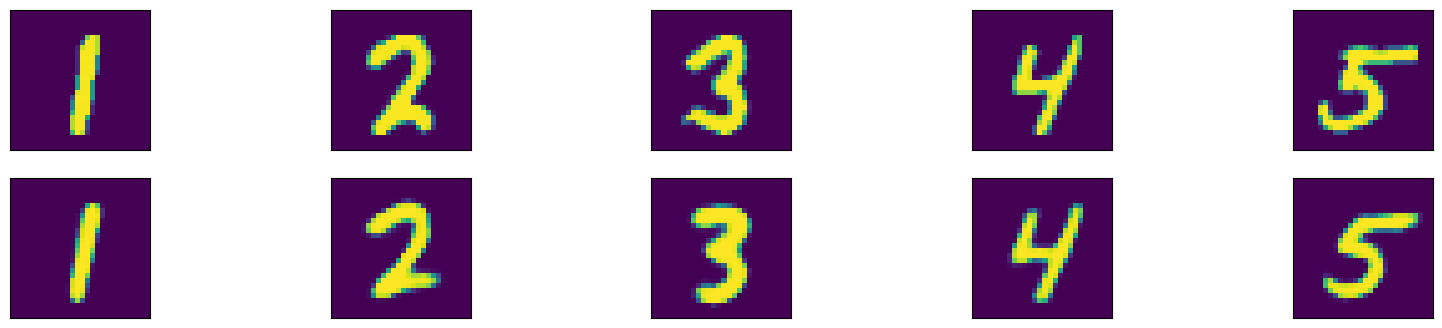

In [ ]:
tl, vl = train_cvae(autoencoder, train_loader, test_loader, optimizer, criterion)

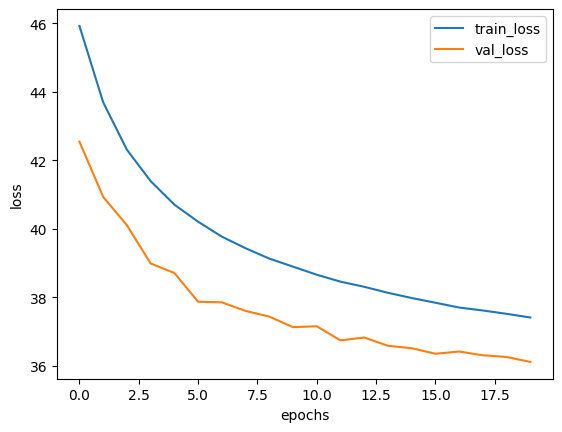

In [ ]:
# Построим кривые обучения
#plt.figure(figsize=(15, 9))
plt.plot(tl, label="train_loss")
plt.plot(vl, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
NUM_SAMPLES = 16

autoencoder.eval()
with torch.no_grad():
    pic = test_loader.dataset[0][0]
    # Получим латентный вектор
    mu, _ = autoencoder.encode(pic[None, :, :, :].to(DEVICE), torch.tensor([7]).to(DEVICE))
    z = mu.repeat(NUM_SAMPLES,1)

    # Попробуем погенерить из него картинки случайных цифр!
    digits = torch.randint(10, (NUM_SAMPLES,))
    print(digits.flatten(), '<- Генерим эти цифры')

    res = autoencoder.decode(z, digits.to(DEVICE))
    output = res.view(-1, 1, 28, 28).cpu().detach().numpy()

tensor([1, 7, 6, 8, 9, 3, 4, 0, 9, 0, 3, 8, 3, 4, 2, 5]) <- Генерим эти цифры


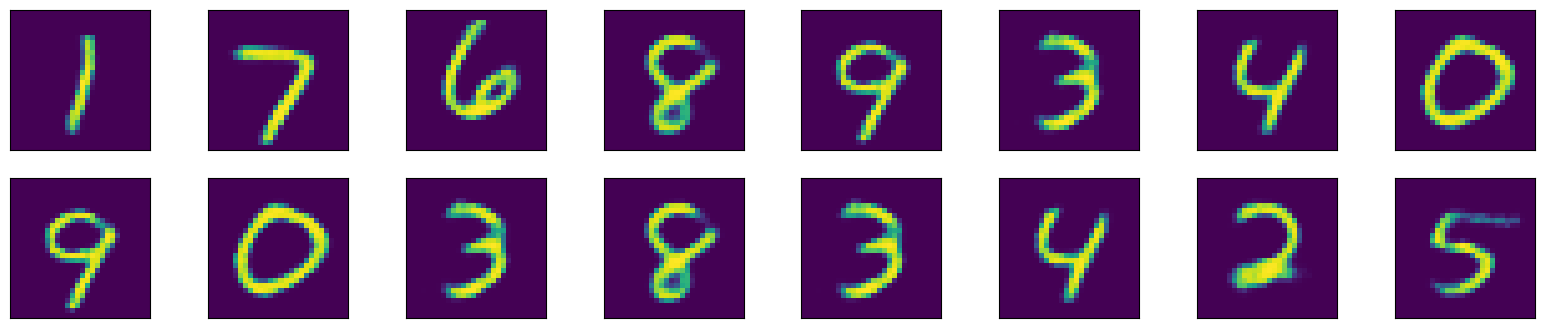

In [ ]:
show_samples(output[:8], output[8:], 8)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
NUM_SAMPLES = 7000
labels, z = [], []

autoencoder.eval()
with torch.no_grad():
    for j in range(NUM_SAMPLES):
        pic = test_loader.dataset[j][0]
        l = test_loader.dataset[j][1]
        labels.append(l)
        mu, _ = autoencoder.encode(pic[None, :, :, :].to(DEVICE), torch.tensor([l]).to(DEVICE))
        z.append(mu.detach().cpu().numpy())

In [ ]:
from sklearn.manifold import TSNE

X = torch.Tensor(z).squeeze(1)
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(X)
X_embedded.shape

(7000, 2)

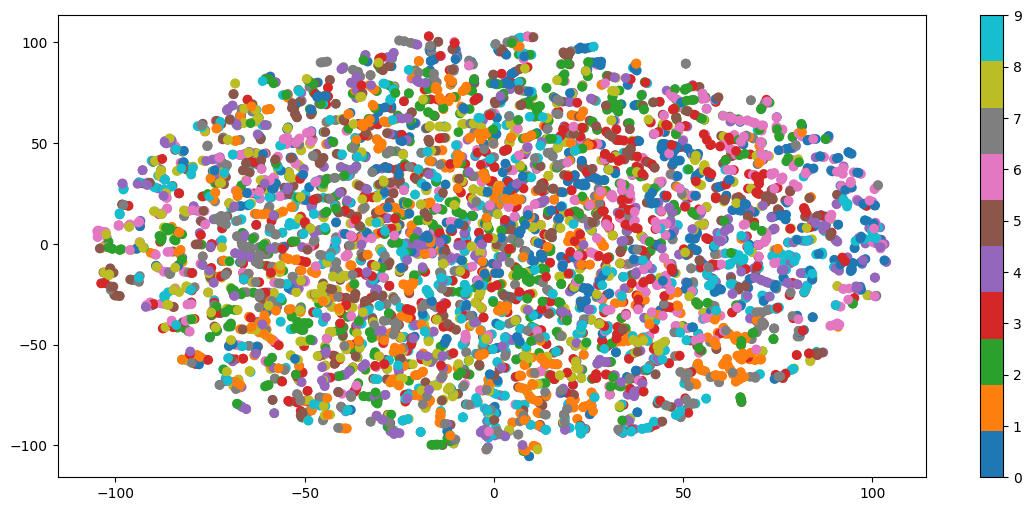

In [ ]:
plt.figure(figsize=(14, 6))
s = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(s)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Теперь кластеризация отсутсвует - любая точка пространства может быть интерпретирована декодером в соответствие с заданной меткой класса.